# Task for Today  

***

## Clothing Review Rating Prediction  

Given *reviews of women's clothing*, let's try to predict whether the rating associated with the review will be **5-star** or not.

We will use a TensorFlow/Keras recurrent neural network to make our predictions.

# Getting Started

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

In [2]:
data = pd.read_csv('../input/ecommerce-reviews-for-women-clothings/Womens-Clothing-E-Commerce-Reviews.csv')

In [3]:
data

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses
23485,23485,1104,52,Please make more like this one!,This dress in a lovely platinum is feminine an...,5,1,22,General Petite,Dresses,Dresses
23486,23486,1097,32,Overall,This one suits me well,5,1,21,General Petite,Dresses,Dresses


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23488 entries, 0 to 23487
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23488 non-null  int64 
 1   Clothing ID              23488 non-null  int64 
 2   Age                      23488 non-null  int64 
 3   Title                    19678 non-null  object
 4   Review Text              22643 non-null  object
 5   Rating                   23488 non-null  int64 
 6   Recommended IND          23488 non-null  int64 
 7   Positive Feedback Count  23488 non-null  int64 
 8   Division Name            23474 non-null  object
 9   Department Name          23474 non-null  object
 10  Class Name               23474 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


# Preprocessing

In [5]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop rows with missing reviews
    missing_review_rows = df[df['Review Text'].isna()].index
    df = df.drop(missing_review_rows, axis=0).reset_index(drop=True)
    
    
    # Use only the review and rating column
    y = df['Rating']
    X = df['Review Text']
    
    
    # Make y a binary target
    y = y.apply(lambda x: 1 if x == 5 else 0)
    
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    
    # Learn the vocabulary
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    
    
    # Find the size of the vocabulary
    vocab_length = len(tokenizer.word_index) + 1
    print("Vocab length:", vocab_length)
    
    
    # Convert review texts into sequences of integers
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    
    
    # Find the maximum sequence length
    max_seq_length = np.max(list(map(lambda x: len(x), X_train)))
    print("Maximum sequence length:", max_seq_length)
    
    
    # Pad the sequences to by uniform length
    X_train = pad_sequences(X_train, maxlen=max_seq_length, padding='post')
    X_test = pad_sequences(X_test, maxlen=max_seq_length, padding='post')
    
    
    return X_train, X_test, y_train, y_test, vocab_length, max_seq_length

In [6]:
X_train, X_test, y_train, y_test, VOCAB_LENGTH, MAX_SEQ_LENGTH = preprocess_inputs(data)

Vocab length: 12726
Maximum sequence length: 115


In [7]:
X_train.shape

(15850, 115)

In [8]:
X_test.shape

(6793, 115)

# Training

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 115)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 115, 128)     1628928     input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 14720)        0           embedding[0][0]                  
__________________________________________________________________________________________________
gru (GRU)                       (None, 256)          296448      embedding[0][0]                  
______________________________________________________________________________________________

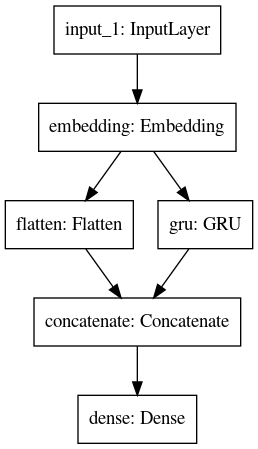

In [9]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

word_embedding = tf.keras.layers.Embedding(
    input_dim=VOCAB_LENGTH,
    output_dim=128,
    input_length=MAX_SEQ_LENGTH
)(inputs)

word_flatten = tf.keras.layers.Flatten()(word_embedding)
gru = tf.keras.layers.GRU(256, return_sequences=False, activation='tanh')(word_embedding)

concat = tf.keras.layers.concatenate([word_flatten, gru])

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(concat)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())
tf.keras.utils.plot_model(model)

In [10]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
397/397 [==============================] - 14s 25ms/step - loss: 0.6309 - accuracy: 0.6365 - val_loss: 0.4623 - val_accuracy: 0.7934
Epoch 2/100
397/397 [==============================] - 10s 25ms/step - loss: 0.3643 - accuracy: 0.8518 - val_loss: 0.4473 - val_accuracy: 0.7962
Epoch 3/100
397/397 [==============================] - 9s 24ms/step - loss: 0.2035 - accuracy: 0.9345 - val_loss: 0.4857 - val_accuracy: 0.7880
Epoch 4/100
397/397 [==============================] - 9s 24ms/step - loss: 0.1051 - accuracy: 0.9765 - val_loss: 0.5124 - val_accuracy: 0.7883
Epoch 5/100
397/397 [==============================] - 10s 25ms/step - loss: 0.0584 - accuracy: 0.9895 - val_loss: 0.5533 - val_accuracy: 0.7880


# Results

In [11]:
model.evaluate(X_test, y_test)

213/213 [==============================] - 1s 4ms/step - loss: 0.4562 - accuracy: 0.7963


[0.45620599389076233, 0.7962608337402344]

# Data Every Day  

This notebook is featured on Data Every Day, a YouTube series where I train models on a new dataset each day.  

***

Check it out!  
https://youtu.be/EY_dMXXtazg